In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model,Sequential 
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras.layers import LSTM, GRU
from keras import optimizers
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# import all stock prices
df_stock = pd.read_csv("NASDAQ_Composite.csv", index_col = 0)
df_stock.head()

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted
TIMESTAMP,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,1.931380e+09,2308.419922
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2.367860e+09,2308.709961
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2.253340e+09,2301.090088
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2.270050e+09,2300.050049
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2.145390e+09,2317.169922


In [3]:
# Economic Policy Uncertainty Index for United States 
df_uncertainty = pd.read_csv("USEPUINDXD.csv", index_col = 0)
df_uncertainty.head()

,USEPUINDXD
DATE,
2010-01-01,174.55
2010-01-02,119.52
2010-01-03,216.95
2010-01-04,150.35
2010-01-05,151.16


In [4]:
# ICE BofA US High Yield Index Option-Adjusted Spread
df_interest_rate = pd.read_csv("BAMLH0A0HYM2.csv", index_col = 0)
df_interest_rate.head()

,BAMLH0A0HYM2
DATE,
2010-01-04,6.34
2010-01-05,6.30
2010-01-06,6.17
2010-01-07,6.03
2010-01-08,6.02


In [5]:
# Replace the bad value with value nearby
df_interest_rate.loc[df_interest_rate.BAMLH0A0HYM2 == '.'] = np.nan
df_interest_rate[['BAMLH0A0HYM2']] = df_interest_rate[['BAMLH0A0HYM2']].apply(pd.to_numeric)
df_interest_rate['BAMLH0A0HYM2'].interpolate(method='linear', inplace=True)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2641 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
BAMLH0A0HYM2    2641 non-null float64
dtypes: float64(1)
memory usage: 41.3+ KB


In [6]:
set_stock_dates = set(df_stock.index)
set_rate_dates = set(df_interest_rate.index)
set_uncertainty_dates = set(df_uncertainty.index)

# Take the difference between the sets and print
print(set_stock_dates - set_rate_dates)
print(set_stock_dates - set_uncertainty_dates)

set()
set()


In [7]:
# Merge stocks and bonds DataFrames using join()
df = df_stock.join(df_interest_rate, how='left')
df = df.join(df_uncertainty, how='left')
df.head(10)

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted,BAMLH0A0HYM2,USEPUINDXD
TIMESTAMP,,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,1.931380e+09,2308.419922,6.34,150.35
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2.367860e+09,2308.709961,6.30,151.16
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2.253340e+09,2301.090088,6.17,95.95
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2.270050e+09,2300.050049,6.03,92.20
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2.145390e+09,2317.169922,6.02,141.92
2010-01-11,2324.780029,2326.280029,2302.209961,2312.409912,2.077890e+09,2312.409912,5.99,103.54
2010-01-12,2297.280029,2298.850098,2272.699951,2282.310059,2.368320e+09,2282.310059,6.07,99.13
2010-01-13,2289.459961,2313.030029,2274.120117,2307.899902,2.318350e+09,2307.899902,6.03,69.67
2010-01-14,2303.310059,2322.560059,2303.290039,2316.739990,2.254170e+09,2316.739990,6.04,87.42


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 2010-01-04 to 2019-12-30
Data columns (total 8 columns):
IXIC.Open        2515 non-null float64
IXIC.High        2515 non-null float64
IXIC.Low         2515 non-null float64
IXIC.Close       2515 non-null float64
IXIC.Volume      2515 non-null float64
IXIC.Adjusted    2515 non-null float64
BAMLH0A0HYM2     2515 non-null float64
USEPUINDXD       2515 non-null float64
dtypes: float64(8)
memory usage: 256.8+ KB


In [9]:
df.describe()

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted,BAMLH0A0HYM2,USEPUINDXD
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03,2515.000000,2515.000000,2515.000000
mean,4741.647273,4766.420162,4714.043359,4742.476513,1.964577e+09,4742.476513,4.994185,103.942111
std,1877.365514,1885.525754,1867.997740,1877.282870,3.977521e+08,1877.282870,1.228051,59.891208
min,2099.659912,2110.659912,2061.139893,2091.790039,1.494100e+08,2091.790039,3.160000,3.320000
25%,2973.875000,2990.934936,2959.095093,2976.155029,1.736800e+09,2976.155029,3.935000,61.670000
50%,4623.770020,4651.899902,4570.229980,4620.370117,1.913230e+09,4620.370117,4.740000,89.610000
75%,6229.260009,6255.950195,6200.430175,6227.930175,2.141375e+09,6227.930175,5.915000,130.655000
max,9049.469727,9052.000000,8987.320313,9022.389648,4.553600e+09,9022.389648,9.100000,490.890000


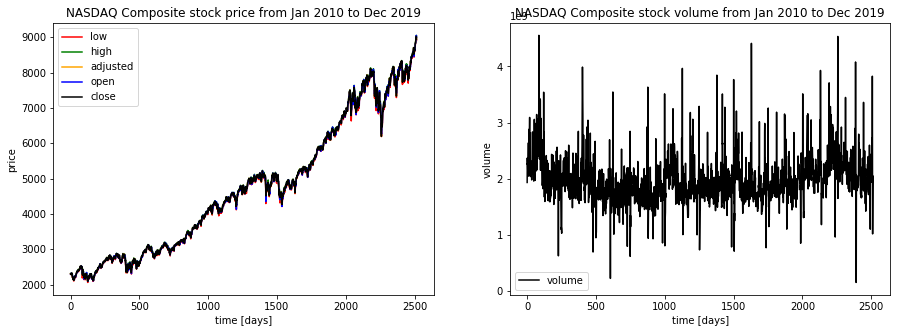

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(df['IXIC.Low'].values, color='red', label='low')
plt.plot(df['IXIC.High'].values, color='green', label='high')
plt.plot(df['IXIC.Adjusted'].values, color='orange', label='adjusted')
plt.plot(df['IXIC.Open'].values, color='blue', label='open')
plt.plot(df['IXIC.Close'].values, color='black', label='close')
plt.title('NASDAQ Composite stock price from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')


plt.subplot(1,2,2)
plt.plot(df['IXIC.Volume'].values, color='black', label='volume')
plt.title('NASDAQ Composite stock volume from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

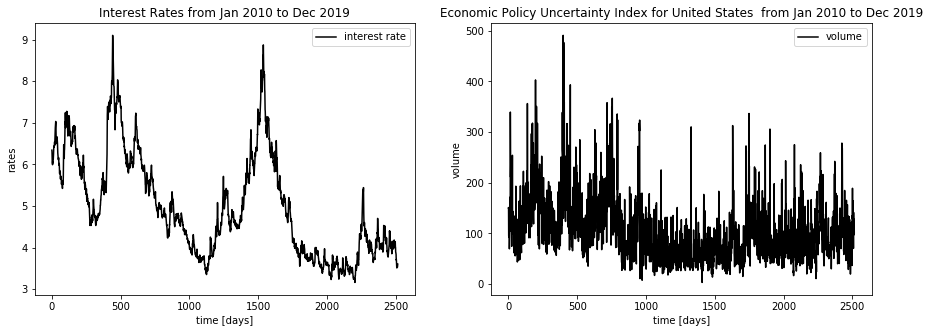

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(df.BAMLH0A0HYM2.values, color='black', label='interest rate')
plt.title('Interest Rates from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('rates')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(df.USEPUINDXD.values, color='black', label='volume')
plt.title('Economic Policy Uncertainty Index for United States  from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

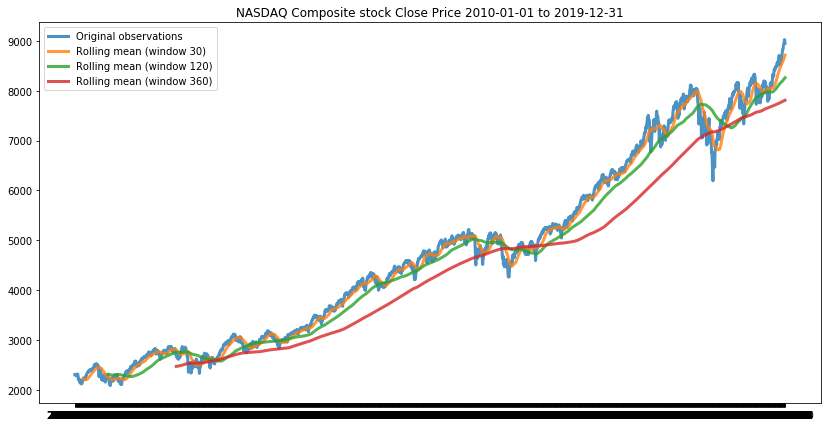

In [12]:
# Moving average
close = df['IXIC.Close']
MA30 = close.rolling(window=30).mean()
MA120 = close.rolling(window=120).mean()
MA360 = close.rolling(window=360).mean()
plt.figure(figsize=(14, 7))
plt.plot(close.index, close, lw=3, alpha=0.8, label='Original observations')
plt.plot(close.index, MA30, lw=3, alpha=0.8, label='Rolling mean (window 30)')
plt.plot(close.index, MA120, lw=3, alpha=0.8, label='Rolling mean (window 120)')
plt.plot(close.index, MA360, lw=3, alpha=0.8, label='Rolling mean (window 360)')
plt.title('NASDAQ Composite stock Close Price 2010-01-01 to 2019-12-31')
plt.legend(loc='best')
plt.show()

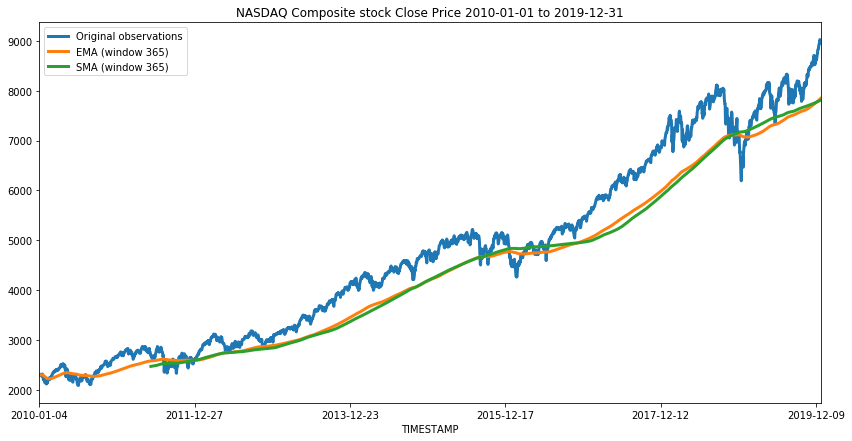

In [13]:
# Exponential Moving Average
exp_weighted_mean = close.ewm(span=360).mean()
sma_d10 = close.rolling(window=360).mean()
ax = close.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='EMA (window 365)')
sma_d10.plot(ax=ax, lw=3, label='SMA (window 365)')
plt.title('NASDAQ Composite stock Close Price 2010-01-01 to 2019-12-31')
plt.legend(loc='best')
plt.show()

From the above chart, you can see EMA in orange line catches the downwards movement in Dec 2015 and Dec 2018 faster than SMA in green line. And also at early 2016, EMA started to catch upwards movement, while SMA still showing downwards trend.

In [14]:
# Generate more features for prediction from Exponential Moving Average
df['EMA120'] = df['IXIC.Close'].ewm(span=120, adjust=False).mean()
df['EMA360'] = df['IXIC.Close'].ewm(span=360, adjust=False).mean()

df['dist_EMA120'] = (df['IXIC.Close'] - df['EMA120'])/df['EMA120']*100
df['dist_EMA360'] = (df['IXIC.Close'] - df['EMA360'])/df['EMA360']*100

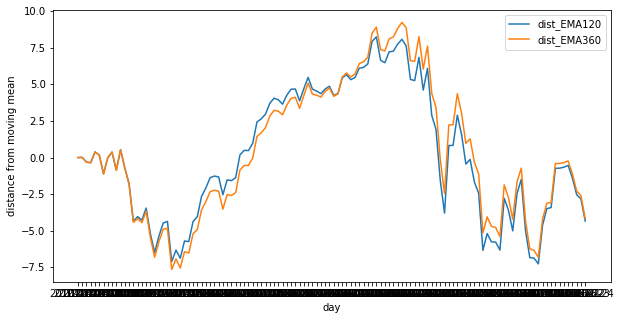

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_stock.index[:120], df['dist_EMA120'][:120], label='dist_EMA120')
ax.plot(df_stock.index[:120], df['dist_EMA360'][:120], label='dist_EMA360')
ax.set_xlabel('day')
ax.set_ylabel('distance from moving mean')
ax.legend(loc='best')

# LSTM Data Preparation

The first step is to prepare the dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the close stock price at the current day given all the features at the prior time step.

In [16]:
# split the dataset into two parts: a training set (2010-2018) and a test set (2019).
df_train = df['2010-01-01':'2018-12-31']
df_test = df['2019-01-01':'2019-12-31']
print('Length of data from Jan 2010 to Dec 2018 is', df_train.shape[0])
print('Length of data from Jan 2019 to Dec 2019 is', df_test.shape[0])

Length of data from Jan 2010 to Dec 2018 is 2264
Length of data from Jan 2019 to Dec 2019 is 251


In [17]:
features = ['IXIC.Open', 'IXIC.Close', 'IXIC.High', 'IXIC.Low', 'IXIC.Adjusted', 'IXIC.Volume',
            'BAMLH0A0HYM2', 'dist_EMA120', 'dist_EMA360']

# get data value
values = df[features].values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028022   0.031257   0.028883   0.033679   0.031257   0.404608   
2   0.029873   0.031299   0.029255   0.033854   0.031299   0.503714   
3   0.029936   0.030199   0.029304   0.033863   0.030199   0.477711   
4   0.028552   0.030049   0.027464   0.032353   0.030049   0.481505   
5   0.027710   0.032520   0.029813   0.033131   0.032520   0.453200   

   var7(t-1)  var8(t-1)  var9(t-1)   var2(t)  
1   0.535354   0.584685   0.368056  0.031299  
2   0.528620   0.585139   0.368418  0.030199  
3   0.506734   0.573194   0.358905  0.030049  
4   0.483165   0.571754   0.357658  0.032520  
5   0.481481   0.598789   0.379084  0.031833  


In [19]:
# split into train and test sets
values = reframed.values
train = values[0:-251, :]
test = values[-251:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2263, 1, 9) (2263,) (251, 1, 9) (251,)


In [20]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mean_squared_error'])
history = model.fit(X_train, y_train, epochs=50, batch_size = 128, 
                    validation_data=(X_test, y_test), shuffle=False)

Train on 2263 samples, validate on 251 samples
Epoch 1/50
2263/2263 [==============================] - 0s 176us/step - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.2460 - val_mean_squared_error: 0.2460
Epoch 2/50
2263/2263 [==============================] - 0s 18us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0855 - val_mean_squared_error: 0.0855
Epoch 3/50
2263/2263 [==============================] - 0s 14us/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0524 - val_mean_squared_error: 0.0524
Epoch 4/50
2263/2263 [==============================] - 0s 17us/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 5/50
2263/2263 [==============================] - 0s 14us/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 6/50
2263/2263 [==============================] - 0s 15us/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.

2263/2263 [==============================] - 0s 16us/step - loss: 7.6386e-05 - mean_squared_error: 7.6386e-05 - val_loss: 1.8115e-04 - val_mean_squared_error: 1.8115e-04
Epoch 47/50
2263/2263 [==============================] - 0s 13us/step - loss: 7.4391e-05 - mean_squared_error: 7.4391e-05 - val_loss: 1.7727e-04 - val_mean_squared_error: 1.7727e-04
Epoch 48/50
2263/2263 [==============================] - 0s 12us/step - loss: 7.2601e-05 - mean_squared_error: 7.2601e-05 - val_loss: 1.7372e-04 - val_mean_squared_error: 1.7372e-04
Epoch 49/50
2263/2263 [==============================] - 0s 12us/step - loss: 7.1001e-05 - mean_squared_error: 7.1001e-05 - val_loss: 1.7047e-04 - val_mean_squared_error: 1.7047e-04
Epoch 50/50
2263/2263 [==============================] - 0s 11us/step - loss: 6.9576e-05 - mean_squared_error: 6.9576e-05 - val_loss: 1.6752e-04 - val_mean_squared_error: 1.6752e-04


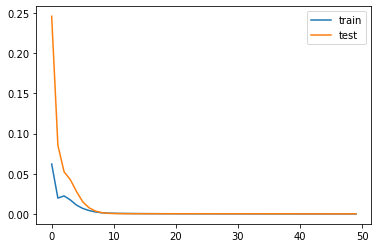

In [22]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], sqrt(testScore[0])))

Train Score: 0.00007 MSE (0.01 RMSE)
Test Score: 0.00017 MSE (0.01 RMSE)


In [24]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

0.962870083774979


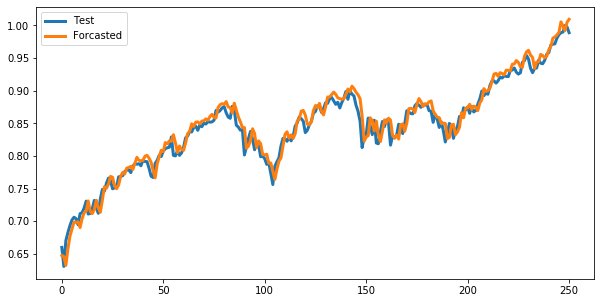

In [25]:
plt.figure(figsize=(10,5))
plt.plot(y_test, linewidth=3)
plt.plot(y_pred, linewidth=3)
plt.legend(('Test','Forcasted'))
plt.show()

In [26]:
def denormalize(df, normalized_value): 
    df = df['IXIC.Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    scaler = MinMaxScaler()
    a = scaler.fit_transform(df)
    return scaler.inverse_transform(normalized_value)

new_pred = denormalize(df[features], y_pred)
new_y_test = denormalize(df, y_test)

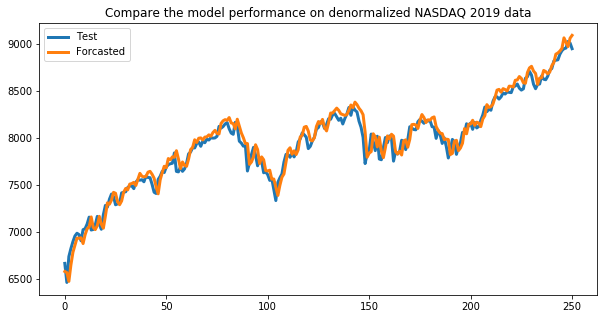

In [27]:
plt.figure(figsize=(10,5))
plt.plot(new_y_test, linewidth=3)
plt.plot(new_pred, linewidth=3)
plt.title('Compare the model performance on denormalized NASDAQ 2019 data')
plt.legend(('Test','Forcasted'))
plt.show()